#### 노트

- 푸리에 변환(Fourier transform)
    - 1차원 시계열 데이터로 해석하는 waveform 에서 나아가
    - 복합파를 다룰 수 있는 
    - 즉, 주파수 대역별로 나누어 별도로 해석해볼 수 있는 방법
        - 오일러 공식
    - 푸리에 변환 이후
        - 복소수 생성
            - 복소수의 절대값 = Spectrum magnitude (주파수의 강도)
            - 복소수의 Phase = Phase Spectrum (주파수의 위상)
                - 실수부
                - 허수부
                
        - STFT(Short Time Fourier Transform)
            - 어느 시간대에 주파수가 변하는지 알기 위해 시간의 길이를 나눠서 푸리에 변환
            - 즉 시간의 흐름에 따른 프리퀀시 영역별 앰플리튜드를 반환
            - **Spectrogram**
                - wav 데이터 해석 방법중 하나
                - 일정 시간동안 wav 데이터 안의 주파수 분포 시각화
                - x 축은 시간 , y 축은 주파수를 나타냄
                
                
            
 


     

#### 도전과제
- Spectrogram classification 모델 구현
    
    1.데이터 처리와 분류
    - 라벨 데이터 처리하기
    - sklearn의 train_test_split함수를 이용하여 train, test 분리
    
    2.학습을 위한 하이퍼파라미터 설정
    
    3.데이터셋 구성
    - tf.data.Dataset을 이용
    - from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용
    - map과 batch를 이용한 데이터 전처리
    - 주의 : waveform을 spectrogram으로 변환하기 위해 추가로 사용하는 메모리 때문에 이후 메모리 부족 현상을 겪게 될수도 있습니다.
    - tf.data.Dataset이 생성된 이후, 아래 예시와 같이 wav 데이터나 spectrogram 데이터를 담아둔 메모리 버퍼를 비워 주면 도움이 됩니다.
    
    del speech_data
    del spec_data
    
    4.2차원 Spectrogram 데이터를 처리하는 모델 구성
    - 2차원 Spectrogram 데이터의 시간축 방향으로 Conv1D layer를 적용, 혹은 Conv2D layer를 적용 가능
    - batchnorm, dropout, dense layer 등을 이용
    - 12개의 단어 class를 구분하는 loss를 사용하고 Adam optimizer를 사용
    - 모델 가중치를 저장하는 checkpoint callback 함수 추가
    - 다양한 모델의 실험을 진행해 보시기 바랍니다.
    
    5.학습 후, 학습이 어떻게 진행됐는지 그래프로 출력
    - loss, accuracy를 그래프로 표현
    
    6.Test dataset을 이용해서 모델의 성능을 평가
    - 저장한 weight 불러오기
    - 모델의 예측값과 정답값이 얼마나 일치하는지 확인



#### 라이브러리 설치


In [ ]:
# FFT 관련 라이브러리 librosa
! pip install librosa 

#### 데이터 불러오기

In [7]:
import numpy as np
import os

data_path = os.getenv("HOME")+'/workplace/aiffel/exp_05/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

#데이터 크기출력
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)


Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)


In [8]:
# 음성데이터 샘플 출력
import IPython.display as ipd
import random

# 데이터 선택 (랜덤하게 선택)
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  38647
Wave data shape :  (8000,)
label :  ['up']


#### 데이터 분리하기

In [9]:
#라벨 데이터 처리
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

#index 작업으로 라벨데이터 변환
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


array([ 3,  3,  3, ..., 11, 11, 11])

In [10]:
# 데이터 분리
from sklearn.model_selection import train_test_split


sr = 8000 # 1초동안 재생되는 샘플의 갯수
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], 
                                                                label_data, 
                                                                test_size=0.2,
                                                                shuffle=True)
print(train_wav)

train_wav = train_wav.reshape([-1, sr, 1]) # add channel for CNN
test_wav = test_wav.reshape([-1, sr, 1])


[[-0.00104365 -0.00086119 -0.00073852 ... -0.00635948 -0.00426746
   0.00138562]
 [ 0.00284221  0.00221396 -0.00015429 ... -0.00519174 -0.00396648
  -0.00714448]
 [ 0.00554282  0.00867072 -0.01323226 ...  0.00274211  0.00139104
  -0.00470204]
 ...
 [-0.00016631  0.00017196 -0.00014058 ... -0.00017694 -0.00024866
  -0.0002089 ]
 [ 0.00670208  0.01543109  0.01239109 ...  0.01106856  0.00896319
   0.00703171]
 [ 0.00157013  0.0029008   0.00209872 ... -0.00113357 -0.00244829
   0.00296195]]


In [11]:
#데이터 분리 확인
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)

train data :  (40496, 8000, 1)
train labels :  (40496,)
test data :  (10124, 8000, 1)
test labels :  (10124,)


#### 하이퍼 파라미터 세팅

In [12]:
batch_size = 16
max_epochs = 4

# the save point
checkpoint_dir = os.getenv('HOME')+'/workplace/aiffel/exp_05/models/wav'

checkpoint_dir #체크포인트 경로 확인 

'/home/aiffel/workplace/aiffel/exp_05/models/wav'

In [13]:
#map 함수를 활용한 데이터 전처리 함수 설정
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

In [14]:
import tensorflow as tf

# 1차원 데이터 분리

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)


<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>


In [15]:
# 2차원 데이터로 변환
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

# 1차원 데이터에서 2차원 데이터로 변환됨
# for train
spec_train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
spec_train_dataset = train_dataset.map(wav2spec)
spec_train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(spec_train_dataset)

# for test
spec_test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
spec_test_dataset = test_dataset.map(wav2spec)
spec_test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

# train_spec = wav2spec(spec_)
# print("Waveform shape : ",data.shape)
# print("Spectrogram shape : ",spec.shape)

TypeError: in user code:

    <ipython-input-15-9f65bf990744>:5 wav2spec  *
        D = np.abs(librosa.stft(wav, n_fft=fft_size))
    /home/aiffel/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:208 stft  *
        fft_window = get_window(window, win_length, fftbins=True)
    /home/aiffel/anaconda3/lib/python3.7/site-packages/librosa/filters.py:884 get_window  *
        return scipy.signal.get_window(window, Nx, fftbins=fftbins)
    /home/aiffel/anaconda3/lib/python3.7/site-packages/scipy/signal/windows/windows.py:2124 get_window  *
        return winfunc(*params)
    /home/aiffel/anaconda3/lib/python3.7/site-packages/scipy/signal/windows/windows.py:790 hann  *
        return general_hamming(M, 0.5, sym)
    /home/aiffel/anaconda3/lib/python3.7/site-packages/scipy/signal/windows/windows.py:1020 general_hamming  *
        return general_cosine(M, [alpha, 1. - alpha], sym)
    /home/aiffel/anaconda3/lib/python3.7/site-packages/scipy/signal/windows/windows.py:112 general_cosine  *
        if _len_guards(M):
    /home/aiffel/anaconda3/lib/python3.7/site-packages/scipy/signal/windows/windows.py:21 _len_guards  *
        if int(M) != M or M < 0:
    /home/aiffel/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:1502 tensor_not_equals
        return gen_math_ops.not_equal(self, other, incompatible_shape_error=False)
    /home/aiffel/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/gen_math_ops.py:6422 not_equal
        name=name)
    /home/aiffel/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:506 _apply_op_helper
        inferred_from[input_arg.type_attr]))

    TypeError: Input 'y' of 'NotEqual' Op has type float32 that does not match type int32 of argument 'x'.


#### 모델 만들기 (기본)

In [16]:
#기본 모델
#오디오 데이터는 1차원 데이터이므로 Conv1D 레이어를 사용하여 모델을 구성한다
#레이어 구축
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(sr, 1))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x) 

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 8000, 32)          320       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8000, 32)          9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4000, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4000, 64)          18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4000, 64)          36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2000, 64)          0     

#### Loss function 1

In [17]:
# 정답클래스가 12개 이므로 이를 구분하기 위해
# multi-class classification가 필요
# Loss funtion으로 Categorical Cross-Entropy loss 함수를 사용

optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])


#### 모델 학습시키기 1
    - Callbak
        - model.fit 함수 이용시, callback 함수를 이용해 학습 중간에 원하는 동작을 하도록 설정 가능
        

In [18]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


In [19]:
# 모델 학습 코드
# 이전 스텝의 배치 사이즈와 에폭 값을 조절하여 최적의 하이퍼 파마미터를 설정하기
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/4
2531/2531 [==============================] - ETA: 0s - loss: 1.5799 - accuracy: 0.4656
Epoch 00001: val_loss improved from inf to 0.99383, saving model to /home/aiffel/workplace/aiffel/exp_05/models/wav
2531/2531 [==============================] - 183s 72ms/step - loss: 1.5799 - accuracy: 0.4656 - val_loss: 0.9938 - val_accuracy: 0.6872
Epoch 2/4
2531/2531 [==============================] - ETA: 0s - loss: 0.9513 - accuracy: 0.7015
Epoch 00002: val_loss improved from 0.99383 to 0.78460, saving model to /home/aiffel/workplace/aiffel/exp_05/models/wav
2531/2531 [==============================] - 185s 73ms/step - loss: 0.9513 - accuracy: 0.7015 - val_loss: 0.7846 - val_accuracy: 0.7504
Epoch 3/4
2531/2531 [==============================] - ETA: 0s - loss: 0.6755 - accuracy: 0.7919
Epoch 00003: val_loss improved from 0.78460 to 0.71093, saving model to /home/aiffel/workplace/aiffel/exp_05/models/wav
2531/2531 [==============================] - 189s 75ms/step - loss: 0.6755 - accu

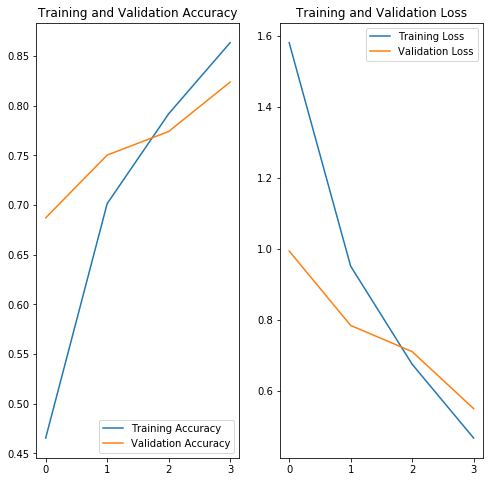

✅


In [20]:
# 학습 결과를 loss 와 accuracy값을 이용하여 시각화
# 주의 : train loss 와 val_loss 의 차이가 커지는 경우는
# -> 오버피팅이 일어나는 것이므로 수정이 필요하다

import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

In [21]:
# 테스트 데이터셋을 이용하여 모델의 성능 평가


# callback 함수의 가중치 불러오기
model_wav.load_weights(checkpoint_dir)


# 테스트 데이터를 이용하여 모델의 예측값과 실제값이 얼마나 일치하는지 확인하기
results = model_wav.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))

# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

633/633 [==============================] - 22s 35ms/step - loss: 0.5506 - accuracy: 0.8238
loss value: 0.551
accuracy value: 82.3785%


In [22]:
# 모델의 테스트셋을 골라 들어보고
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

#테스트 셋의 라벨과 모델의 실제 예측결과를 비교하기
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')


label :  silence
y_pred: silence(Correct!)


#### 모델 만들기 2
- Skip-Connection model 추가하기
- 위쪽의 데이터가 레이어를 뛰어넘어 레이어를 통과한 값에 더해주는 형식으로 구현됨
- 코드예시
    - tf.concat([#layer output tensor, layer output tensor#], axis=#)

In [23]:
#스킵 커넥션 모델 구현

input_tensor = layers.Input(shape=(sr, 1))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)#Skip-Connection model1
skip_2 = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)#Skip-Connection model2
skip_3 = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)#Skip-Connection model3
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav_skip = tf.keras.Model(input_tensor, output_tensor)

model_wav_skip.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8000, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 8000, 32)     320         input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 8000, 32)     9248        conv1d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_4 (MaxPooling1D)  (None, 4000, 32)     0           conv1d_11[0][0]                  
____________________________________________________________________________________________

In [28]:
# 정답클래스가 12개 이므로 이를 구분하기 위해
# multi-class classification가 필요
# Loss funtion으로 Categorical Cross-Entropy loss 함수를 사용

optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


In [29]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


In [31]:
#스킵 커넥션 모델 학습
#이전 스텝의 배치 사이즈와 에폭 값을 조절하여 최적의 하이퍼 파마미터를 설정하기
history_wav2 = model_wav_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/4
2531/2531 [==============================] - ETA: 0s - loss: 0.0800 - accuracy: 0.9859
Epoch 00001: val_loss did not improve from 0.41941
2531/2531 [==============================] - 220s 87ms/step - loss: 0.0800 - accuracy: 0.9859 - val_loss: 0.5082 - val_accuracy: 0.8478
Epoch 2/4
2531/2531 [==============================] - ETA: 0s - loss: 0.0467 - accuracy: 0.9928
Epoch 00002: val_loss did not improve from 0.41941
2531/2531 [==============================] - 231s 91ms/step - loss: 0.0467 - accuracy: 0.9928 - val_loss: 0.6773 - val_accuracy: 0.7994
Epoch 3/4
2531/2531 [==============================] - ETA: 0s - loss: 0.0353 - accuracy: 0.9944
Epoch 00003: val_loss improved from 0.41941 to 0.39989, saving model to /home/aiffel/workplace/aiffel/exp_05/models/wav
2531/2531 [==============================] - 227s 90ms/step - loss: 0.0353 - accuracy: 0.9944 - val_loss: 0.3999 - val_accuracy: 0.8869
Epoch 4/4
2531/2531 [==============================] - ETA: 0s - loss: 0.0262 -

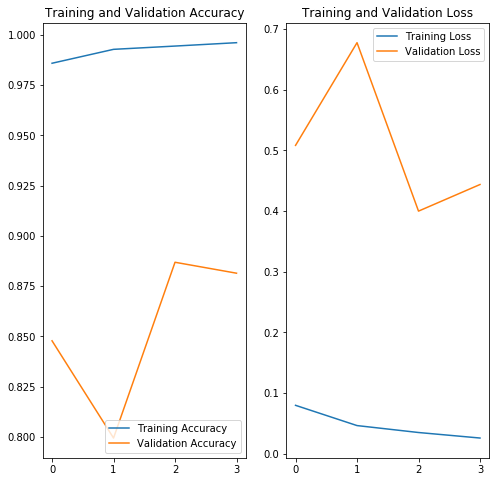

✅


In [32]:
# 학습 결과를 loss 와 accuracy값을 이용하여 시각화
# 주의 : train loss 와 val_loss 의 차이가 커지는 경우는
# -> 오버피팅이 일어나는 것이므로 수정이 필요하다

import matplotlib.pyplot as plt

acc = history_wav2.history['accuracy']
val_acc = history_wav2.history['val_accuracy']

loss=history_wav2.history['loss']
val_loss=history_wav2.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

In [33]:
# #테스트 데이터셋을 이용하여 스킵 커넥션 모델의 성능 평가


# callback 함수의 가중치 불러오기
model_wav_skip.load_weights(checkpoint_dir)


# 테스트 데이터를 이용하여 모델의 예측값과 실제값이 얼마나 일치하는지 확인하기
results = model_wav_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))

# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

633/633 [==============================] - 18s 28ms/step - loss: 0.3996 - accuracy: 0.8869
loss value: 0.400
accuracy value: 88.6902%


In [35]:
# 모델의 테스트셋을 골라 들어보고
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav_skip(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

#테스트 셋의 라벨과 모델의 실제 예측결과를 비교하기
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')


label :  go
y_pred: go(Correct!)


In [ ]:
#푸리에변환 
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D
print("✅")

In [ ]:
#음성데이터 시각화
import librosa.display

librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

In [ ]:
# 위에서 뽑았던 sample data
# 1차원 데이터에서 2차원 데이터로 변환됨

spec = wav2spec(data)
print("Waveform shape : ",data.shape)
print("Spectrogram shape : ",spec.shape)

#### Loss function 

In [ ]:
# 정답클래스가 12개 이므로 이를 구분하기 위해
# multi-class classification가 필요
# Loss funtion으로 Categorical Cross-Entropy loss 함수를 사용

optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

#### 모델 학습시키기
    - Callbak
        - model.fit 함수 이용시, callback 함수를 이용해 학습 중간에 원하는 동작을 하도록 설정 가능
        -

In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

In [ ]:
# 모델 학습 코드
# 이전 스텝의 배치 사이즈와 에폭 값을 조절하여 최적의 하이퍼 파마미터를 설정하기
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

#### 학습 결과확인

In [ ]:
# 학습 결과를 loss 와 accuracy값을 이용하여 시각화
# 주의 : train loss 와 val_loss 의 차이가 커지는 경우는
# -> 오버피팅이 일어나는 것이므로 수정이 필요하다

import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

#### 평가하기

In [ ]:
# 테스트 데이터셋을 이용하여 모델의 성능 평가


# callback 함수의 가중치 불러오기
model_wav.load_weights(checkpoint_dir)


# 테스트 데이터를 이용하여 모델의 예측값과 실제값이 얼마나 일치하는지 확인하기
results = model_wav.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))

# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

#### 모델 실전테스트

In [ ]:
# 모델의 테스트셋을 골라 들어보고
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

#테스트 셋의 라벨과 모델의 실제 예측결과를 비교하기
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')


#### 회고
    - 배운것
        - 데이터를 2d wav로 변환하는 과정이 신기하고 그것을 시각화 하는것이 마치 초음파 사진을 보는것 같다
    - 느낀것
        -일단 업로드
    - 얻은것
    - 할것